# In-class exercise 8: PyTorch from the bottom up

Based on Jeremy Howard's PyTorch tutorial "What is torch.nn really?"

In this tutorial we will start at [PyTorch](https://pytorch.org/docs)'s lowest layer and then gradually introduce functions and features until we arrive at `nn.Sequential`. Lower layers give you more control over what you want to do, while higher layers allow for faster implementations. So in practice you have to choose at which layer you want to work. Moreover, knowing how the lower layers work will give you a better understanding of what is happening behind the scenes when working with the higher level abstractions.

In [111]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time

# Download the data
In this tutorial we will be working with the MNIST dataset. This is a classic dataset consisting of black and white images of hand-drawn digits.

We will use [torchvision](https://pytorch.org/docs/stable/torchvision) to download the dataset. Torchvision also provides a lot of functionality for data preprocessing and augmentation, which is beyond the scope of this tutorial.

In [112]:
mnist_dev = torchvision.datasets.MNIST('./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True)

The input data $\mathbf{X}$ and targets $\mathbf{y}$ are saved in `data` and `targets`, so we will at first just extract these and work with the raw data. We also convert them to values between 0 and 1.

In [113]:
x_dev = mnist_dev.data / 255.0
y_dev = mnist_dev.targets

MNIST consists of 60,000 28x28 images, each corresponding to a single digit (0 to 9).

torch.Size([60000, 28, 28])
torch.Size([60000])


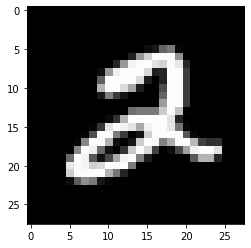

In [114]:
print(x_dev.shape)
print(y_dev.shape)

plt.imshow(x_dev[5], cmap='gray')

Note that setting `train=True` gives you the development set, i.e. both training and validation data. So we need to split this further.

In [115]:
ntrain = 50_000
x_train, y_train = x_dev[:ntrain].flatten(1), y_dev[:ntrain]
x_val, y_val = x_dev[ntrain:].flatten(1), y_dev[ntrain:]

In [116]:
a = np.array([1,2,3,4])
print(a)
print(a[1:])
print(a[:1])

[1 2 3 4]
[2 3 4]
[1]


# torch.tensor
PyTorch uses its own `torch.tensor` datatype. This is very similar to a Numpy Array, but can also be moved to and used for calculations on a GPU, and supports storing gradient information and hence dynamic backpropagation.

We start by manually setting up an affine layer. The special function `requires_grad` tells PyTorch that these weights require gradients. PyTorch will then record all operations done on the tensor, so backpropagation can be done automatically. Thanks to this ability we can use any normal function as a model in PyTorch.

Note that we initialize the weights via Xavier (Glorot) initialization. We only activate gradients after initialization, since we don't want gradients for that.

Appending a function with `_` in PyTorch denotes in-place operations.

In [117]:
num_features = 28 * 28  #fan-in
num_classes = 10        #fan-out

weight = torch.randn(num_features, num_classes) * np.sqrt(2 / (num_features + num_classes))
weight.requires_grad_()
bias = torch.zeros(num_classes, requires_grad=True)

In [118]:
weight

tensor([[ 0.0396, -0.0645,  0.0050,  ..., -0.1255, -0.0191, -0.0336],
        [ 0.0174,  0.0312, -0.0805,  ...,  0.0119,  0.0334,  0.0206],
        [-0.0850,  0.0594,  0.0389,  ..., -0.0322, -0.0110,  0.0524],
        ...,
        [ 0.0216, -0.0170, -0.0306,  ...,  0.0486,  0.0766,  0.0228],
        [ 0.0401,  0.0651, -0.0544,  ..., -0.0910, -0.0967,  0.0273],
        [-0.0436, -0.0003, -0.0164,  ...,  0.0345,  0.0296,  0.0032]],
       requires_grad=True)

We now use these weights to create a simple linear model (i.e. logistic regression). We furthermore define a loss (negative log-likelihood) for training and a function to obtain the prediction accuracy.

In [119]:
def model(input):
    return log_softmax(input @ weight + bias)

def log_softmax(input):
    return input - input.exp().sum(-1).log().unsqueeze(-1)

def nll_loss(output, target):
    return -output[range(target.shape[0]), target].mean()
loss_fn = nll_loss

def get_accuracy(output, target):
    pred = torch.argmax(output, dim=1)
    return (pred == target).float().mean()

In [120]:
a = torch.randn(2, 3)
print(a)
b = a.sum(-1, keepdim = True)
print(b)
c = a.sum(-1)
c

tensor([[-0.5479, -2.3132,  0.4013],
        [ 0.8815,  0.3768, -0.9720]])
tensor([[-2.4598],
        [ 0.2864]])


tensor([-2.4598,  0.2864])

Let's see how our model performs before training.

In [121]:
batch_size = 64

print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.1875)


We can now define a training loop. In this loop we need to
1. Get a mini-batch of data. When using dynamic computation graphs like in PyTorch it is important to choose a batch size that is large enough to leverage your hardware properly.
2. Generate predictions with our model
3. Calculate the loss
4. Update the gradients via `loss.backward()`
5. Update the `weight` and `bias` based on the gradients (optimization)

In [122]:
learning_rate = 0.5
num_epochs = 2

for epoch in range(num_epochs):
    for i in range(int(np.ceil(ntrain / batch_size))):
        # Get mini-batch
        start_i = i * batch_size
        end_i = min(start_i + batch_size, ntrain)
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        # Generate predictions
        pred = model(xb)
        
        # Calculate loss
        loss = loss_fn(pred, yb)
        
        # Update gradients
        loss.backward()
        
        # Optimization step
        with torch.no_grad():
            weight -= learning_rate * weight.grad
            bias -= learning_rate * bias.grad
        weight.grad.zero_()
        bias.grad.zero_()

That is all we need! And now we can check if our performance has improved.

In [123]:
print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2287, grad_fn=<NegBackward>)
tensor(0.9375)


Nice, it works! Wasn't this already way easier than with pure Numpy? But this is just the start. Now that we've implemented our model in the lowest level of PyTorch we can start to go up the ladder and make this even better and simpler!

# torch.nn.functional

We will start by replacing some of our hand-written functions with their professionally implemented counterparts in `torch.nn.functional`. This library contains all of the PyTorch functions (other parts contain the classes). It is commonly imported via

In [124]:
import torch.nn.functional as F

Instead of using `log_softmax` and `neg_loglikelihood` we can instead just use `F.cross_entropy`, which combines both of these.

In [125]:
def model(xb):
    return xb @ weight + bias

loss_fn = F.cross_entropy

The loss should still be the same.

In [126]:
print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2287, grad_fn=<NllLossBackward>)


# nn.Module
Next we will use `nn.Module` and `nn.Parameter` for a clearer and more concise model definition and training loop. By subclassing `nn.Module` we obtain various convenience functions such as `.parameters()` and `.zero_grad()`.

In [127]:
from torch import nn

class LogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_features, num_classes) * np.sqrt(2 / (num_features + num_classes)))
        self.bias = nn.Parameter(torch.zeros(num_classes))
        
    def forward(self, input):
        return input @ self.weight + self.bias

In [128]:
# nn.Parameter is similar to nn.Tensor but kind of different 
# https://blog.csdn.net/qq_28753373/article/details/104179354
weight = nn.Parameter(torch.randn(num_features, num_classes) * np.sqrt(2 / (num_features + num_classes)))
weight

Parameter containing:
tensor([[-0.0336, -0.0472, -0.0241,  ..., -0.0077, -0.0058,  0.0821],
        [ 0.0744, -0.0105, -0.0651,  ...,  0.0450,  0.0213, -0.0554],
        [ 0.0098, -0.0983,  0.0020,  ...,  0.0110,  0.0157, -0.0502],
        ...,
        [-0.0162,  0.0563,  0.0099,  ..., -0.0611, -0.1002,  0.0022],
        [-0.0136, -0.0161,  0.0004,  ...,  0.0046, -0.0659,  0.1233],
        [ 0.0203,  0.0527,  0.0057,  ..., -0.0059, -0.0440, -0.0225]],
       requires_grad=True)

Since `LogRegression` is now a class we will have to first instantiate it before using it. We can then call it as if it were a function.

In [129]:
model = LogisticRegression(28 * 28, 10)
print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(2.3611, grad_fn=<NllLossBackward>)


In [130]:
x = torch.tensor([3.0],requires_grad=True)
for t in range(2):
    y = x*x
    print(y)
    y = y.sum()
    y.backward()
    print(y)
    print(x.grad) # x.grad梯度会累加
    # x.grad=None
    


tensor([9.], grad_fn=<MulBackward0>)
tensor(9., grad_fn=<SumBackward0>)
tensor([6.])
tensor([9.], grad_fn=<MulBackward0>)
tensor(9., grad_fn=<SumBackward0>)
tensor([12.])


We can now take advantage of `.parameters()` and `.zero_grad()` to make our training loop more concise.

In [131]:
def fit(model, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil(ntrain / batch_size))): # np.ceil:计算大于等于该值的最小整数
            # Get mini-batch
            start_i = i * batch_size
            end_i = min(start_i + batch_size, ntrain)
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            # Generate predictions
            pred = model(xb)

            # Calculate loss
            loss = loss_fn(pred, yb)

            # Update gradients
            model.zero_grad()  #grad本来是会被累积，但不需要累积，所以每个batch计算前清空grad https://blog.csdn.net/weixin_39504171/article/details/103179067
            loss.backward()

            # Optimization step
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

In [132]:
fit(model, num_epochs=2)

And check if our results are similar to before.

In [133]:
print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2339, grad_fn=<NllLossBackward>)
tensor(0.9531)


# nn.Linear

Instead of manually defining and initializing the affine layer, we can instead use the PyTorch class `nn.Linear`. PyTorch provides a wide range of predefined layers to simplify our code (and make it faster). On GitHub you will find layers for pretty much anything you might want to do.

In [134]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lin = nn.Linear(num_features, num_classes)  # here
        
    def forward(self, input):
        return self.lin(input)

To control weight initialization we must define a function and apply it to the model with `.apply(_)`.

In [135]:
def initialize_weight(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):  #isinstance:判断module是否为括号中的类型
        nn.init.xavier_normal_(module.weight)

Now let's check if we still get the same results as before.

In [136]:
model = LogisticRegression(28 * 28, 10)
model.apply(initialize_weight)  #nn.Module.apply:将module传给指定的function运行一遍

fit(model, num_epochs=2)

print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2243, grad_fn=<NllLossBackward>)
tensor(0.9531)


# torch.optim

`torch.optim` provides various optimization algorithms. Here we will continue to use simple `SGD`, but you could just as easily switch to Adam or AMSgrad. Optimizers provide `.step()` and `.zero_grad()` methods, which allows us to make the last block in our `fit` function more concise.

In [137]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [138]:
def fit(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil(ntrain / batch_size))):
            # Get mini-batch
            start_i = i * batch_size
            end_i = min(start_i + batch_size, ntrain)
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            # Generate predictions
            pred = model(xb)

            # Calculate loss
            loss = loss_fn(pred, yb)

            # Update gradients
            optimizer.zero_grad()  # here
            loss.backward()

            # Optimization step
            optimizer.step()       # and here

In [139]:
fit(model, optimizer, num_epochs=2)

In [140]:
print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.1914, grad_fn=<NllLossBackward>)
tensor(0.9531)


# Dataset
PyTorch also provides an abstract Dataset class for easier handling of various data. You can subclass this just like we subclassed `nn.Module`. A Dataset only needs to provide a `__len__` (which is called by Python's `len` function) and a `__getitem__` function for indexing the dataset.

`TensorDataset` provides an easy way of converting tensors to datasets. This will make our data loading more concise, since we can handle both `x_train` and `y_train` simultaneously.

In [141]:
from torch.utils.data import TensorDataset

train_set = TensorDataset(x_train, y_train)

In [142]:
def fit(model, optimizer, train_set, num_epochs):
    for epoch in range(num_epochs):
        for i in range(int(np.ceil(ntrain / batch_size))):
            # Get mini-batch
            start_i = i * batch_size
            end_i = min(start_i + batch_size, ntrain)
            xb, yb = train_set[start_i:end_i]   # here

            # Generate predictions
            pred = model(xb)

            # Calculate loss
            loss = loss_fn(pred, yb)

            # Update gradients
            optimizer.zero_grad()
            loss.backward()

            # Optimization step
            optimizer.step()

In [143]:
model = LogisticRegression(28 * 28, 10)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, train_set, num_epochs=2)

print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2307, grad_fn=<NllLossBackward>)
tensor(0.9531)


# DataLoader

A `DataLoader` automatically generates mini-batches for your training loop. It can run multiple workers in parallel and provides useful functionality such as data shuffling. You can create a `DataLoader` for any `Dataset`.

In [144]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=batch_size)

Using the DataLoader makes our training loop a lot cleaner:

In [145]:
def fit(model, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        for xb, yb in train_loader:  #here, batch is automatically generated
                    
            # Generate predictions
            pred = model(xb)

            # Calculate loss
            loss = loss_fn(pred, yb)

            # Update gradients
            optimizer.zero_grad()
            loss.backward()

            # Optimization step
            optimizer.step()


In [146]:
model = LogisticRegression(28 * 28, 10)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, train_loader, num_epochs=2)

print(loss_fn(model(x_train[:batch_size]), y_train[:batch_size]))
print(get_accuracy(model(x_train[:batch_size]), y_train[:batch_size]))

tensor(0.2306, grad_fn=<NllLossBackward>)
tensor(0.9375)


# Validation

Now that we have a training loop we can go ahead and do some real work. To avoid overfitting, enable early stopping and have some information for model development we always need a validation set.

Since the validation set does not need backpropagation we can use 2x larger batches for it. Furthermore, we should shuffle our training data to avoid correlation between batches. This is not necessary (and would waste computation time) for the validation set.

In [147]:
train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)

dataloaders = {}
dataloaders['train'] = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(val_set, batch_size=2 * batch_size)

Note that you need to call `model.train()` before training and `model.eval()` before evaluation (inference), since some layers like dropout and batch normalization work differently in each mode.

In [148]:
def fit(model, optimizer, dataloaders, num_epochs):
    for epoch in range(num_epochs):
        
        # Training
        model.train()
        print(model.train())
        for xb, yb in dataloaders['train']:
            pred = model(xb)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        print(model.eval())
        loss = 0
        for xb, yb in dataloaders['val']:
            pred = model(xb)
            loss += loss_fn(pred, yb).sum()
        avg_loss = loss / len(dataloaders['val'])
            
        print(f"Epoch {epoch}: {avg_loss:.3f}")

In [149]:
model = LogisticRegression(28 * 28, 10)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fit(model, optimizer, dataloaders, num_epochs=2)

LogisticRegression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)
LogisticRegression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 0: 0.307
LogisticRegression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)
LogisticRegression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1: 0.291


# CNN
Using simple logistic regression (or an MLP) for images basically ignores the data's underlying structure. We can do much better than this by switching to a CNN. Since our training loop does not assume anything about the model we can train a CNN without any changes.

Our CNN will consist of 3 convolutional layers, each using PyTorch's predefined `Conv2d` layer. At the End, we perform average pooling. Since `Conv2d` assumes a shape of `[batch_size, num_channels, height, width]` we need to reshape our input inside the model via `.view(_)`.  https://www.cnblogs.com/siyuan1998/p/10809646.html

In [158]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, stride=2, padding=1)
        # 参数含义：输入通道数，输出通道数，卷积核大小，步幅，padding
        # 输入通道数取决于图片类型，RGB就是3，黑白就是1
        # 输出通道数取决于卷积核的数量。此时的 out_channels 也会作为下一次卷积时的卷积核的 in_channels
        # https://blog.csdn.net/qq_34107425/article/details/104117670
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_channels, num_classes, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        #print(xb.shape)
        start = time.clock()
        xb = xb.view(-1, 1, 28, 28)  # view:将数据转化成括号中对应的维度，-1表示自动判断
        # 这里分别表示：batch中图片个数，图片通道数，图片高度，图片宽度
        t1 = time.clock()
        xb = F.relu(self.conv1(xb))
        t2 = time.clock()
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        print("t1: ", t1-start)
        print("t2: ", t2-t1)
        return xb.view(-1, xb.size(1))

We will now furthermore use momentum in our optimizer to speed up training.

In [159]:
model = CNN(num_channels=16, num_classes=10)
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

fit(model, optimizer, dataloaders, num_epochs=2)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
t1:  0.0004480000000057771
t2:  0.0023429999999962092
t1:  2.600000001962144e-05
t2:  0.0010499999999922238
t1:  1.900000000887303e-05
t2:  0.0005539999999939482
t1:  1.8000000011397788e-05
t2:  0.0006379999999808206
t1:  1.900000000887303e-05
t2:  0.0005919999999832726
t1:  1.899999998045132e-05
t2:  0.0005760000000236687
t1:  3.299999997352643e-05
t2:  0.001527000000010048
t1:  1.900000000887303e-05
t2:  0.0006740000000036162
t1:  1.6000000016447302e-05
t2:  0.0005409999999983484
t1:  3.399999999942338e-05
t2:  0.0011609999999961929
t1:  1.9999999977926564e-05
t2:  0.0006790000000194141
t1:  2.3999999996249244e-05
t2:  0.0008799999999951069
t1:  1.9999999977926564e-05
t2:  0.0006800000000168893
t1:  2.1000000003823516e-05
t2:  0.0007909999999924366
t1

/Users/hpj123/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/hpj123/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/hpj123/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


t1:  1.900000000887303e-05
t2:  0.0007090000000005148
t1:  1.900000000887303e-05
t2:  0.001197999999988042
t1:  1.900000000887303e-05
t2:  0.0007150000000137879
t1:  2.6999999988674972e-05
t2:  0.0009970000000123491
t1:  3.000000000952241e-05
t2:  0.0007469999999898391
t1:  2.9000000012047167e-05
t2:  0.0008469999999931588
t1:  2.599999999119973e-05
t2:  0.0014600000000086766
t1:  4.200000000764703e-05
t2:  0.0010120000000028995
t1:  3.500000002532033e-05
t2:  0.001050999999989699
t1:  3.000000000952241e-05
t2:  0.0010159999999928004
t1:  2.4999999993724487e-05
t2:  0.0010890000000074451
t1:  2.200000000129876e-05
t2:  0.0007809999999892625
t1:  2.0000000006348273e-05
t2:  0.0006799999999884676
t1:  1.6000000016447302e-05
t2:  0.000552999999996473
t1:  1.8000000011397788e-05
t2:  0.000602999999983922
t1:  1.9999999977926564e-05
t2:  0.0007220000000245363
t1:  1.7000000013922545e-05
t2:  0.0005510000000015225
t1:  2.2999999998774e-05
t2:  0.0008390000000133568
t1:  1.6999999985500835e-0

t1:  1.7000000013922545e-05
t2:  0.0007929999999873871
t1:  1.499999999055035e-05
t2:  0.0005140000000096734
t1:  1.7000000013922545e-05
t2:  0.0007129999999904157
t1:  2.2999999998774e-05
t2:  0.0007779999999968368
t1:  1.499999999055035e-05
t2:  0.000545000000016671
t1:  1.899999998045132e-05
t2:  0.0005859999999984211
t1:  1.8000000011397788e-05
t2:  0.0006309999999984939
t1:  1.6000000016447302e-05
t2:  0.0005579999999838492
t1:  1.6000000016447302e-05
t2:  0.0005709999999794491
t1:  1.5999999988025593e-05
t2:  0.0005309999999951742
t1:  1.6000000016447302e-05
t2:  0.0005219999999894753
t1:  1.7000000013922545e-05
t2:  0.0005419999999958236
t1:  1.499999999055035e-05
t2:  0.000572000000005346
t1:  1.500000001897206e-05
t2:  0.0005189999999970496
t1:  1.7999999982976078e-05
t2:  0.0006060000000047694
t1:  1.8000000011397788e-05
t2:  0.000621999999992795
t1:  1.8000000011397788e-05
t2:  0.0006150000000104683
t1:  1.9999999977926564e-05
t2:  0.0006110000000205673
t1:  2.00000000063482

t1:  1.7999999982976078e-05
t2:  0.0006230000000186919
t1:  1.7000000013922545e-05
t2:  0.0008090000000038344
t1:  4.100000001017179e-05
t2:  0.0008359999999925094
t1:  1.9999999977926564e-05
t2:  0.0006250000000136424
t1:  1.9999999977926564e-05
t2:  0.0006750000000010914
t1:  1.899999998045132e-05
t2:  0.0007209999999986394
t1:  2.2999999998774e-05
t2:  0.0005730000000028213
t1:  1.7000000013922545e-05
t2:  0.000572000000005346
t1:  1.8000000011397788e-05
t2:  0.0005940000000066448
t1:  1.900000000887303e-05
t2:  0.0005769999999927222
t1:  1.8000000011397788e-05
t2:  0.0005500000000040473
t1:  1.7999999982976078e-05
t2:  0.000568000000015445
t1:  1.8000000011397788e-05
t2:  0.0005679999999870233
t1:  1.6000000016447302e-05
t2:  0.0005409999999983484
t1:  1.9999999977926564e-05
t2:  0.0008470000000215805
t1:  1.899999998045132e-05
t2:  0.0005810000000110449
t1:  1.9999999977926564e-05
t2:  0.0006099999999946704
t1:  1.6000000016447302e-05
t2:  0.0005519999999989977
t1:  1.899999998045

KeyboardInterrupt: 

# nn.Sequential

PyTorch provides a class `nn.Sequential` for simplifying the definition of modules that only consist of a stack of layers. Since these are exactly the models we have been using so far we will now switch to this interface.

Because not all functions are defined as PyTorch layers we will start by defining a module that just converts a function to a layer.

In [75]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

We can now define our CNN in a more concise manner. Note that we now use `nn.AdaptiveAvgPool2d`, which allows us to specify the size of the output tensor instead of the input tensor.

In [86]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), # 参数是output_size，可以是数组表示输出的高和宽，也可是int表示输出为方形，或者none表示和input_size相同
    Lambda(lambda x: x.view(x.size(0), -1)),
)
print(model)

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): AdaptiveAvgPool2d(output_size=1)
  (8): Lambda()
)


In [77]:
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

fit(model, optimizer, dataloaders, num_epochs=2)

Epoch 0: 0.316
Epoch 1: 0.246


# GPUs

PyTorch can run significantly faster on a GPU than on a CPU, so you should always try to leverage that hardware. To do so, you need to move both your model and your data to the device.

So let's first check if you have a GPU and choose the appropriate device.

In [78]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

False


Next, we move our model to the device.

In [41]:
model.to(device);

Then, we redefine the DataLoader to pin the memory. This is a trick that will accelerate moving data between CPU and GPU.

In [42]:
dataloaders = {}
dataloaders['train'] = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloaders['val'] = DataLoader(val_set, batch_size=2 * batch_size, pin_memory=True)

Finally, we need to slightly change our training loop to send each batch to the device first.

In [43]:
def fit(model, optimizer, dataloaders, num_epochs):
    for epoch in range(num_epochs):
        
        # Training
        model.train()
        for xb, yb in dataloaders['train']:
            xb, yb = xb.to(device), yb.to(device)
            
            pred = model(xb)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        loss = 0
        for xb, yb in dataloaders['val']:
            xb, yb = xb.to(device), yb.to(device)
            
            pred = model(xb)
            loss += loss_fn(pred, yb).sum()
            
        avg_loss = loss / len(dataloaders['val'])
            
        print(f"Epoch {epoch}: {avg_loss:.3f}")

And now we can run our CNN on the GPU!

In [44]:
model.apply(initialize_weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

fit(model, optimizer, dataloaders, num_epochs=2)

Epoch 0: 0.466
Epoch 1: 0.288


# Summary
Great, so now we have a concise, but general training loop and know how to quickly define new models! Now let us sum up what we have learned during this journey:
- `torch.tensor`: PyTorch tensors work like Numpy arrays, but can remember gradients and be sent to the GPU.
- `torch.nn`
    - `torch.nn.functional`: Provides various useful functions (non stateful) for training neural networks, e.g. activation and loss functions.
    - `nn.Module`: Subclass from this to create a callable that acts like a function, but can remember state. It knows what `Parameter`s and submodules it contains and provides various functionality based on that.
    - `nn.Parameter`: Wraps a tensor and tells the containing Module that it needs updating during backpropagation.
    - `torch.nn`: Many useful layers are already implemented in this library, e.g. `nn.Linear` or `nn.Conv2d`.
    - `nn.Sequential`: Provides an easy way of defining purely stacked modules.
- `torch.optim`: Optimizers such as `SGD` or `Adam`, which let you easily update and train the `Parameter`s inside the passed model.
- `Dataset`: Interface for data using only the `__len__` and `__getitem__` functions. Tensors can be converted into a `Dataset` by using `TensorDataset`.
- `DataLoader`: Takes any `Dataset` and provides an iterator for returning mini-batches with various advanced functionality.
- `GPU`: To use your GPU you need to move your model and each mini-batch to your GPU using `.to(device)`.